In [28]:
import sqlite3

import os
import re

import numpy as np
# It is apparently officially accepted to explicitly
# list all the functions you need from numpy:
from numpy import array, zeros, exp, random, dot
from numpy import shape, reshape, meshgrid, linspace
from numpy import hstack, vstack

import pandas as pd
print('Panda Version:', pd.__version__)

# Set ipython's max row display
pd.set_option('display.max_row', 100, 'display.max_columns', 25)

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100 # highres display

import tensorflow as tf
from tensorflow import Variable

from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed, RepeatVector

from keras.optimizers import SGD

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import LSTM, Dense, Concatenate

from keras.optimizers import SGD

import collections
from collections import Counter

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import signal

# Import date class from datetime module
import time
import datetime
# import datetime as dt
from datetime import date
print("Today date is: ", date.today())

Panda Version: 2.2.2
Today date is:  2024-07-01


In [29]:
!pwd

!ls -la /workspace/data/crypto_md/

/workspace/leo
total 39536
drwxrwxr-x 1 1000 1000    1598 Jul  1 20:50 .
drwxrwxr-x 1 1000 1000      18 Jun  3 23:40 ..
-rw------- 1 1000 1000 1449984 Jun  4 00:49 20240601.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun  3 23:44 20240602.mktdata.ohlcv.db
-rw------- 1 1000 1000 1437696 Jun  4 16:45 20240603.mktdata.ohlcv.db
-rw------- 1 1000 1000 1269760 Jun  5 10:00 20240604.mktdata.ohlcv.db
-rw------- 1 1000 1000 1081344 Jun  6 10:00 20240605.mktdata.ohlcv.db
-rw------- 1 1000 1000 1441792 Jun  7 10:00 20240606.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun  8 10:00 20240607.mktdata.ohlcv.db
-rw------- 1 1000 1000 1449984 Jun  9 10:00 20240608.mktdata.ohlcv.db
-rw------- 1 1000 1000 1437696 Jun 10 10:00 20240609.mktdata.ohlcv.db
-rw-r--r-- 1 1000 1000       0 Jun 12 15:29 20240609.mktdata.ohlcvdb
-rw------- 1 1000 1000 1437696 Jun 11 10:00 20240610.mktdata.ohlcv.db
-rw------- 1 1000 1000 1449984 Jun 12 10:01 20240611.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun 13 10:

In [82]:
# db_conn = sqlite3.connect(mktdata_db_file)
# tables_df = pd.read_sql_query("select * from sqlite_master where type = 'table'", db_conn)
# print (tables_df_20240601.head())

In [52]:
directory = "/workspace/data/crypto_md"

# List of dates
dates = ['20240601', 
         '20240602', 
         '20240603',
         '20240604', 
         '20240605', 
         '20240606', 
         '20240607', 
         '20240608',
         '20240609',
         '20240610',
         '20240611',
         '20240612',
         '20240613', 
         '20240614', 
         '20240615', 
         '20240616',  
         '20240617',
         '20240618',
         '20240619',
         '20240620',
         '20240621', 
         '20240622', 
         '20240623',
         '20240624',
         '20240625', 
         '20240626',
         '20240627',
         '20240628',
         '20240629',
         '20240630']
         # '20240701']
   
# Create an entirely empty DataFrame
df_concat = pd.DataFrame()

for date in dates:
    # Construct the filename
    filename = f"{directory}/{date}.mktdata.ohlcv.db"
    
    # Create the SQLite connection
    conn = sqlite3.connect(filename)
    
    # Read the data into a DataFrame
    df = pd.read_sql_query("select * from coinbase_ohlcv_1min", conn)

    df_concat = pd.concat([df_concat, df], axis = 0,ignore_index = True)
    # Print the combined DataFrame
    # print(df_concat.shape[0])
    # print(df_concat.shape[1])
    conn.close()
print(df_concat.shape[0])
print(df_concat.head(2))
print(df_concat.tail(2))

170211
                tstamp exchange_id instrument_id      open      high  \
0  1717200000000000000    COINBASE  PAIR-BTC-USD  67473.07  67514.99   
1  1717200060000000000    COINBASE  PAIR-BTC-USD  67506.57  67515.00   

        low     close    volume          vwap  
0  67468.13  67506.03  2.045049  67496.869352  
1  67480.66  67494.74  0.646759  67500.893305  
                     tstamp exchange_id instrument_id    open    high     low  \
170209  1719791880000000000    COINBASE  PAIR-XRP-USD  0.4754  0.4755  0.4752   
170210  1719791940000000000    COINBASE  PAIR-XRP-USD  0.4754  0.4754  0.4753   

         close       volume      vwap  
170209  0.4752  1673.163942  0.475444  
170210  0.4753  4375.796190  0.475368  


In [55]:
df_concat['tstamp'] = pd.to_datetime(df_concat['tstamp'])

# Extract individual components

df_concat['year'] = df_concat['tstamp'].dt.year
df_concat['month'] = df_concat['tstamp'].dt.month
df_concat['day'] = df_concat['tstamp'].dt.day
df_concat['hour'] = df_concat['tstamp'].dt.hour
df_concat['minute'] = df_concat['tstamp'].dt.minute
df_concat['second'] = df_concat['tstamp'].dt.second

df_concat['date'] = df_concat['day'].astype(str) + '-' + df_concat['hour'].astype(str) + '-' + df_concat['minute'].astype(str)
df_concat = df_concat.sort_values(by = ['day', 'hour', 'minute'])

selected_columns = ['date', 'instrument_id', 'close', 'volume', 'vwap']
df_concat = df_concat[selected_columns]

instrument_list = df_concat['instrument_id'].unique().tolist()
print("Distinct values in column 'instrument_id':", instrument_list)



Distinct values in column 'instrument_id': ['PAIR-BTC-USD', 'PAIR-ETH-USD', 'PAIR-LTC-USD', 'PAIR-XRP-USD']


In [56]:
# BTC
df_concat_btc = df_concat[df_concat['instrument_id'] == 'PAIR-BTC-USD']

# Reset Index
df_concat_btc = df_concat_btc.reset_index(drop = True)

# Rename Vars
df_concat_btc['close_btc'] = df_concat_btc['close']/100000.00
df_concat_btc['volume_btc'] = df_concat_btc['volume']
df_concat_btc['vwap_btc'] = df_concat_btc['vwap']/100000.00

df_concat_btc = df_concat_btc.drop('close', axis = 1)
df_concat_btc = df_concat_btc.drop('volume', axis = 1)
df_concat_btc = df_concat_btc.drop('vwap', axis = 1)
df_concat_btc = df_concat_btc.drop('instrument_id', axis = 1)

# print (df_concat_btc.head(3))

# LTC
df_concat_ltc = df_concat[df_concat['instrument_id'] == 'PAIR-LTC-USD']

# Reset Index
df_concat_ltc = df_concat_ltc.reset_index(drop = True)

# Rename Vars
df_concat_ltc['close_ltc'] = df_concat_ltc['close']/100.00
df_concat_ltc['volume_ltc'] = df_concat_ltc['volume']
df_concat_ltc['vwap_ltc'] = df_concat_ltc['vwap']/100.00

df_concat_ltc = df_concat_ltc.drop('close', axis = 1)
df_concat_ltc = df_concat_ltc.drop('volume', axis = 1)
df_concat_ltc = df_concat_ltc.drop('vwap', axis = 1)
df_concat_ltc = df_concat_ltc.drop('instrument_id', axis = 1)

# print (df_concat_ltc.head(3))

# ETH
df_concat_eth = df_concat[df_concat['instrument_id'] == 'PAIR-ETH-USD']

# Reset Index
df_concat_eth = df_concat_eth.reset_index(drop = True)

# Rename Vars
df_concat_eth['close_eth'] = df_concat_eth['close']/10000.00
df_concat_eth['volume_eth'] = df_concat_eth['volume']
df_concat_eth['vwap_eth'] = df_concat_eth['vwap']/10000.00

df_concat_eth = df_concat_eth.drop('close', axis = 1)
df_concat_eth = df_concat_eth.drop('volume', axis = 1)
df_concat_eth = df_concat_eth.drop('vwap', axis = 1)
df_concat_eth = df_concat_eth.drop('instrument_id', axis = 1)

# print (df_concat_eth.head(3))

# XRP
df_concat_xrp = df_concat[df_concat['instrument_id'] == 'PAIR-XRP-USD']

# Reset Index
df_concat_xrp = df_concat_xrp.reset_index(drop = True)

# Rename Vars
df_concat_xrp['close_xrp'] = df_concat_xrp['close']
df_concat_xrp['volume_xrp'] = df_concat_xrp['volume']
df_concat_xrp['vwap_xrp'] = df_concat_xrp['vwap']

df_concat_xrp = df_concat_xrp.drop('close', axis = 1)
df_concat_xrp = df_concat_xrp.drop('volume', axis = 1)
df_concat_xrp = df_concat_xrp.drop('vwap', axis = 1)
df_concat_xrp = df_concat_xrp.drop('instrument_id', axis = 1)

# print (df_concat_xrp.head(3))

df_M1 = pd.merge(df_concat_xrp, df_concat_eth, on = 'date', how = 'outer')
# print (df_M1.head(3))
# print ("M1:  ", df_M1.shape[0])
df_M2 = pd.merge(df_M1, df_concat_ltc, on = 'date', how = 'outer')
# print (df_M2.head(3))
# print ("M2:  ", df_M2.shape[0])
df_M3 = pd.merge(df_M2, df_concat_btc, on = 'date', how = 'outer')
# print (df_M3.head(3))
# print ("M3:  ", df_M3.shape[0])

# Drop rows with any NaN value and assign it to a new DataFrame
sample = df_M3.dropna(axis = 0).reset_index(drop = True)
print ("========================================")
print (sample.head(3))
sample_size = sample.shape[0]
print ("test sample size: ", sample_size)

     date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  vwap_eth  \
0   1-0-0     0.5173  28809.165339  0.517217   0.376204   37.497964  0.376108   
1   1-0-1     0.5170  10184.511212  0.517060   0.375942   11.703305  0.376013   
2  1-0-10     0.5176  15515.348778  0.517601   0.375938   11.922897  0.375935   

   close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  vwap_btc  
0     0.8317  110.056253  0.831662   0.675060    2.045049  0.674969  
1     0.8312  176.868598  0.831441   0.674947    0.646759  0.675009  
2     0.8311   58.951033  0.831037   0.675507    1.201335  0.675478  
test sample size:  42544


In [ ]:
# Create a figure and axis object
fig, ax = plt.subplots(2 , 1)

# Plot the data
ax[0].plot(df_concat_btc['date'], df_concat_btc['close_btc'], 'blue')
# ax[0].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')

# Customize the plot
ax[0].set_title('PAIR-BTC-USDT')
ax[0].set_xlabel('date')
ax[0].set_ylabel('close')

ax[1].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')
# ax[1].plot(df_concat_btc['date'], df_concat_btc['volume_BTC'], 'red')

# Show the plot
plt.show()

In [57]:
split_index = round(sample.shape[0] * 0.8)

# First part of the DataFrame
sample_test = sample.iloc[:split_index]

# Second part of the DataFrame
sample_valid = sample.iloc[split_index:]

print("\nFirst part of the DataFrame:")
print (sample_test.tail(2))

print("\nSecond part of the DataFrame:")
print (sample_valid.head(2))


First part of the DataFrame:
          date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
34033  30-3-12     0.4705  23903.550015  0.470389   0.336016   26.085988   
34034  30-3-13     0.4704   2874.524770  0.470399   0.335908    5.563220   

       vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  \
34033  0.336069     0.7532   77.639105  0.752861   0.607710    0.166529   
34034  0.335966     0.7531   37.653148  0.752865   0.607414    0.811043   

       vwap_btc  
34033  0.607675  
34034  0.607543  

Second part of the DataFrame:
          date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
34035  30-3-14     0.4703    433.136168  0.470274   0.335963   13.152171   
34036  30-3-15     0.4704  10739.731198  0.470326   0.336184   12.567832   

       vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  \
34035  0.335893     0.7531   18.631439  0.753011   0.607389    1.337421   
34036  0.336058     0.7528   42.495271  0.752919   

In [58]:
# Original Model, to repeat
# ==============================
# variables are close and volume
# ==============================
#  Test Sample --- 06.20.2024
# ==============================
sample_size = sample_test.shape[0]
print ('sample_size: ', sample_size)

# Model Input
# ========================================
sl = 36 # <--- sequence length
batch = 1  # <--- batch size
n_features = 4 # <---- no. of variables
n_out = 4 # <----- no. of predicted variables
frwd =  1 # <--- how many to predict

# Trimming Indices !!!
# Marking selected rows
sample_test['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_test.index, size = batch, replace = False)

sample_test.loc[selected_indices, 'Selected'] = 1 # print (sample_test[sample_test['Selected'] == 1])
chosen_idx1 = sample_test[sample_test['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)

all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

all_ts_volume_xrp = np.empty((1, )) # final input/output
all_ts_volume_eth = np.empty((1, )) # final input/output
all_ts_volume_ltc = np.empty((1, )) # final input/output
all_ts_volume_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output


aft_ts_close_xrp = np.empty((1))
aft_ts_close_eth = np.empty((1))
aft_ts_close_ltc = np.empty((1))
aft_ts_close_btc = np.empty((1))


for idx in chosen_idx3:
  selected_rows_before = sample_test.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_test.iloc[max(0, idx): idx+frwd]

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  
# Compute standard deviation
  std_dev_xrp = np.std(sr_before_close_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
# Compute the weighted average
  weighted_avg_xrp = np.average(sr_after_close_xrp, weights = sr_after_volume_xrp)
  # print ('XRP w.average:  ', weighted_avg_xrp)

# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])
# Compute standard deviation
  std_dev_eth = np.std(sr_before_close_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
# Compute the weighted average
  weighted_avg_eth = np.average(sr_after_close_eth, weights = sr_after_volume_eth)
  # print ('ETH w.average:  ', weighted_avg_eth)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])
# Compute standard deviation
  std_dev_ltc = np.std(sr_before_close_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
# Compute the weighted average
  weighted_avg_ltc = np.average(sr_after_close_ltc, weights = sr_after_volume_ltc)
  # print ('LTC w.average:  ', weighted_avg_ltc)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])
# Compute standard deviation
  std_dev_btc = np.std(sr_before_close_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
# Compute the weighted average
  weighted_avg_btc = np.average(sr_after_close_btc, weights = sr_after_volume_btc)
  # print ('BTC w.average:  ', weighted_avg_btc)


# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))
# ltc
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_ltc))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))


  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))


X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]

X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]
X_BTC_stdev = stdev_btc[1:]

# X0 = np.column_stack((X_XRP_close, X_XRP_volume, 
#                       X_ETH_close, X_ETH_volume, 
#                       X_LTC_close, X_LTC_volume, 
#                       X_BTC_close, X_BTC_volume))

X0 = np.column_stack((X_XRP_close,
                      X_ETH_close,
                      X_LTC_close,
                      X_BTC_close))
# print (X0)





# ======== Model Input =========
X = X0.reshape(batch-cnt_thrown_idx, sl, n_features)
print ('XXXX ====== Actual Input ====== XXXX')
print (X)
print (X.shape)

y_XRP = aft_ts_close_xrp[1:]
y_ETH = aft_ts_close_eth[1:]
y_LTC = aft_ts_close_ltc[1:]
y_BTC = aft_ts_close_btc[1:]

y0 = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
# print (y0)

y = y0.reshape(batch-cnt_thrown_idx, frwd, n_out)
print ('YYYY ====== Actual Input ====== YYYY')
print (y)
print (y.shape)

sample_size:  34035
[19934]
XXXX ====== Actual Input ====== XXXX
[[[0.4903    0.350729  0.7377    0.6455032]
  [0.4903    0.350877  0.7377    0.6457926]
  [0.4905    0.350933  0.7378    0.6459017]
  [0.4905    0.351024  0.7377    0.6459088]
  [0.4887    0.35135   0.7407    0.6460095]
  [0.4889    0.351423  0.7406    0.6462003]
  [0.4888    0.351417  0.7406    0.6461287]
  [0.4891    0.35157   0.7409    0.6463387]
  [0.4911    0.3515    0.738     0.6463418]
  [0.4913    0.351714  0.7376    0.6466298]
  [0.4902    0.351286  0.7368    0.6462171]
  [0.4901    0.351246  0.7368    0.6460858]
  [0.4908    0.351296  0.7372    0.6462293]
  [0.4909    0.351368  0.7368    0.6463424]
  [0.491     0.351486  0.7371    0.6465279]
  [0.4909    0.351606  0.7372    0.6469269]
  [0.4908    0.351709  0.7362    0.6467869]
  [0.491     0.351545  0.7362    0.6466154]
  [0.4916    0.351287  0.736     0.6465932]
  [0.4914    0.35129   0.7362    0.6466617]
  [0.4908    0.351293  0.7374    0.6459877]
  [0.4923  

/tmp/ipykernel_29/4116522689.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_test['Selected'] = 0


In [ ]:
'''
    06.26.2014           Trends and Seasonalities
========================================================
'''

In [22]:
X0 = np.column_stack((X_XRP_close,
                      X_ETH_close,
                      X_LTC_close,
                      X_BTC_close))


In [59]:
print (type(X0))
print (X0.shape)

<class 'numpy.ndarray'>
(36, 4)


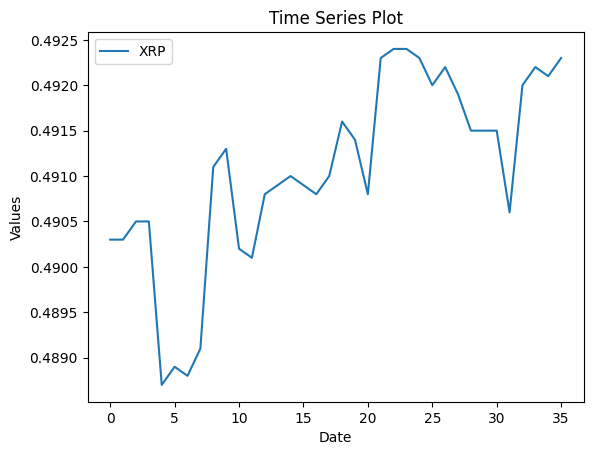

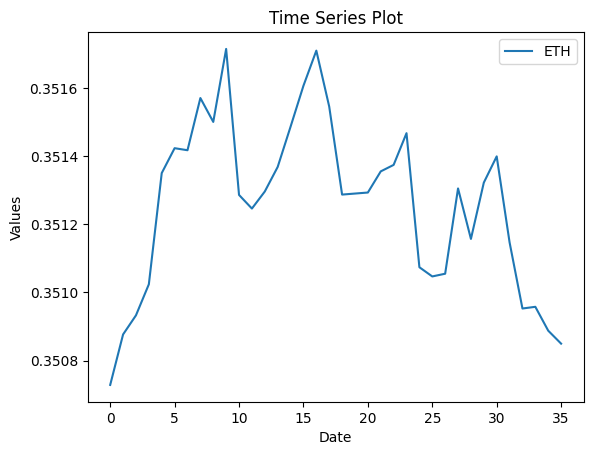

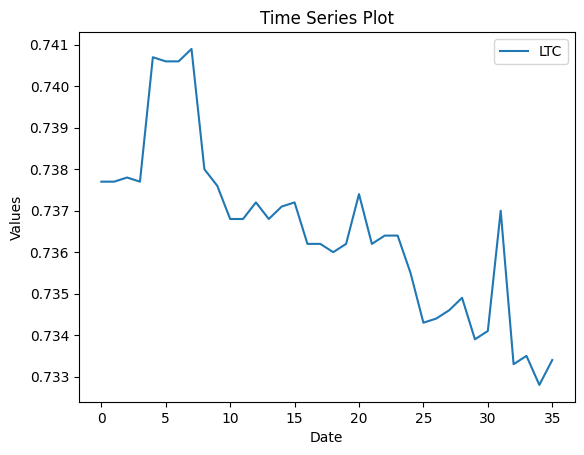

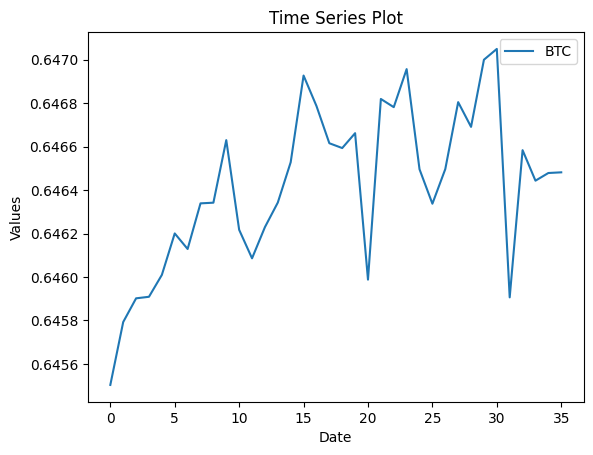

In [74]:
crypto_list = ['XRP', 'ETH', 'LTC', 'BTC']
df_trend = pd.DataFrame(X0, columns = crypto_list)

# print (crypto_list)
for crypto in crypto_list:
    fig, ax = plt.subplots()
    ax.plot(df_trend.index, df_trend[crypto], label = crypto)
    # ax.plot(df.index, df['B'], label='B')
    # ax.plot(df.index, df['C'], label='C')
    # ax.plot(df.index, df['D'], label='D')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    ax.set_title('Time Series Plot')
    ax.legend()
    plt.show()

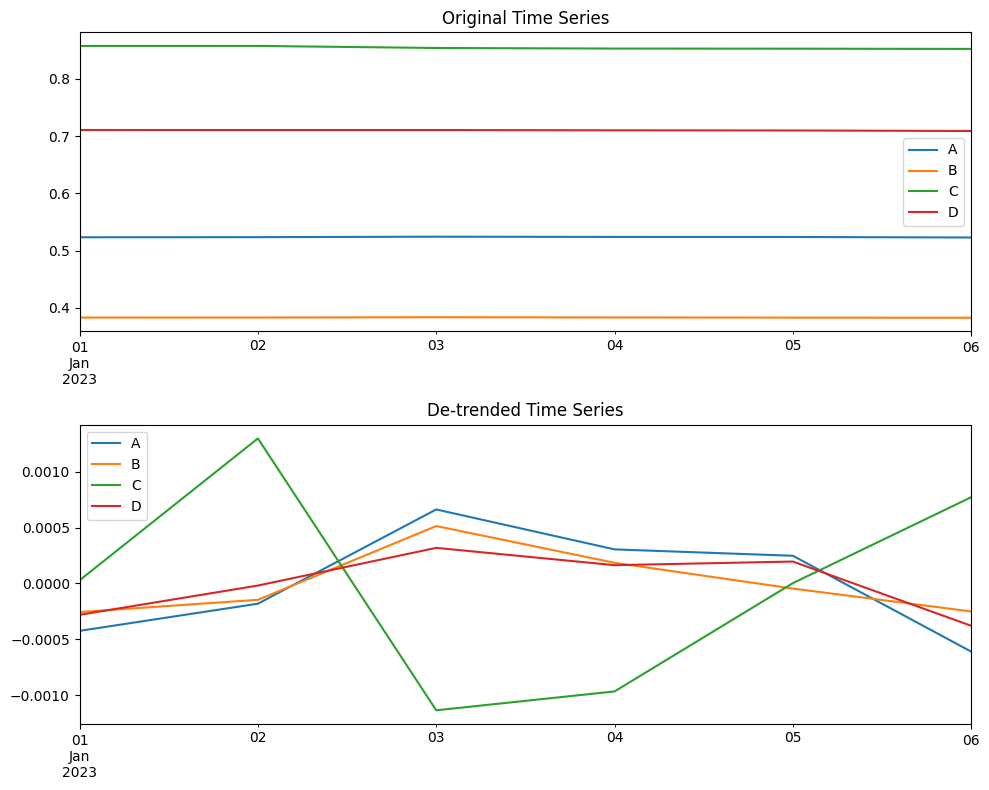

In [63]:
data = np.array([
    [0.5233, 0.383067, 0.8573, 0.7105592],
    [0.5235, 0.383102, 0.8574, 0.7105005],
    [0.5243, 0.383687, 0.8538, 0.710517],
    [0.5239, 0.383284, 0.8528, 0.7100418],
    [0.5238, 0.382979, 0.8526, 0.7097535],
    [0.5229, 0.3827, 0.8522, 0.7088585]
])

df = pd.DataFrame(data, columns=['A', 'B', 'C', 'D'])
df.index = pd.date_range(start='2023-01-01', periods=len(df), freq='D')

# Function to de-trend a series
def detrend_series(series):
    x = np.arange(len(series))
    y = series.values  # Ensure we are using the values of the series
    trend = np.polyfit(x, y, 1)
    trend_line = np.polyval(trend, x)
    detrended_series = series - trend_line
    return detrended_series

# Apply de-trending to each column in the DataFrame
df_detrended = df.apply(detrend_series)

# Plot the original and de-trended time series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

df.plot(ax=axes[0], title='Original Time Series')
df_detrended.plot(ax=axes[1], title='De-trended Time Series')

plt.tight_layout()
plt.show()

In [92]:
def detrend_series(series):
    trend = np.polyfit(np.arange(len(series)), series.values, 1)
    trend_line = np.polyval(trend, np.arange(len(series)))
    detrended_series = series - trend_line
    return detrended_series

df_detrended = df.apply(detrend_series)

36
[7.49806950e-05 4.89748949e-01]
[0.48974895 0.48982393 0.48989891 0.48997389 0.49004887 0.49012385
 0.49019883 0.49027381 0.49034879 0.49042378 0.49049876 0.49057374
 0.49064872 0.4907237  0.49079868 0.49087366 0.49094864 0.49102362
 0.4910986  0.49117358 0.49124856 0.49132354 0.49139852 0.4914735
 0.49154849 0.49162347 0.49169845 0.49177343 0.49184841 0.49192339
 0.49199837 0.49207335 0.49214833 0.49222331 0.49229829 0.49237327]
0     0.000551
1     0.000476
2     0.000601
3     0.000526
4    -0.001349
5    -0.001224
6    -0.001399
7    -0.001174
8     0.000751
9     0.000876
10   -0.000299
11   -0.000474
12    0.000151
13    0.000176
14    0.000201
15    0.000026
16   -0.000149
17   -0.000024
18    0.000501
19    0.000226
20   -0.000449
21    0.000976
22    0.001001
23    0.000926
24    0.000752
25    0.000377
26    0.000502
27    0.000127
28   -0.000348
29   -0.000423
30   -0.000498
31   -0.001473
32   -0.000148
33   -0.000023
34   -0.000198
35   -0.000073
Name: XRP, dtype: float

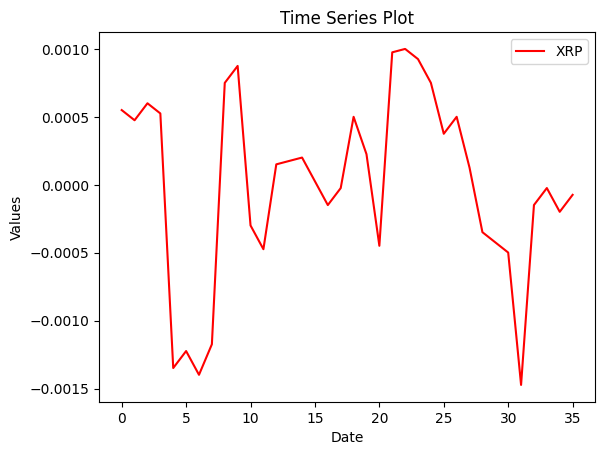

In [95]:
df_trend = pd.DataFrame(X0, columns = crypto_list)

# print (df_trend)

# for crypto in crypto_list:

print (len(df_trend))

trend = np.polyfit(np.arange(len(df_trend)), df_trend[crypto_list[0]], 1)
print (trend)

trend_line = np.polyval(trend, np.arange(len(df_trend)))
print (trend_line)

detrended_series = df_trend[crypto_list[0]] - trend_line
print (detrended_series)

fig, ax = plt.subplots()
# ax.plot(df_trend.index, df_trend[crypto_list[0]], label = crypto_list[0], color = 'blue')
ax.plot(df_trend.index, detrended_series, label = crypto_list[0], color = 'red')
# ax.plot(df_trend.index, trend_line, label = crypto_list[0], color = 'red')
# # ax.plot(df.index, df['C'], label='C')
# # ax.plot(df.index, df['D'], label='D')

ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('Time Series Plot')
ax.legend()
plt.show()

In [86]:
print (trend)
print (trend[0])
print (trend[1])

[7.49806950e-05 4.89748949e-01]
7.498069498070488e-05
0.489748948948949


In [290]:
print (trend[0]*0 + trend[1])
print (trend[0]*(len(df_trend)-1) + trend[1])

0.4946327327327326
0.49703948948948984


In [9]:
# 06.05.2024 just helper
values = X_XRP_close.reshape(batch-cnt_thrown_idx, sl)

print (values[0])
print (np.mean(values[0]))
print (np.std(values[0]))

[0.4961 0.4961 0.4966 0.4956 0.4956 0.4958 0.4959 0.4961]
0.495975
0.00030720514318610995


0


<Figure size 1200x600 with 0 Axes>

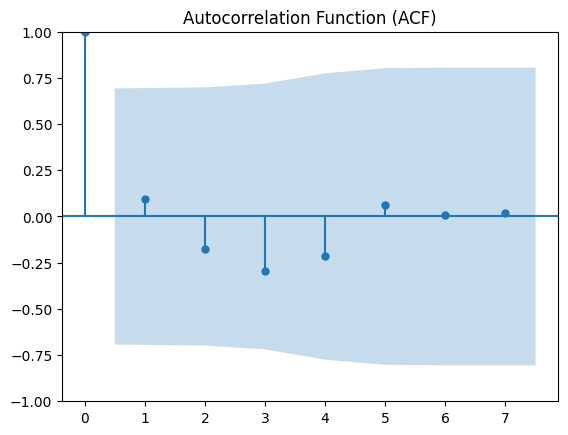

1


<Figure size 1200x600 with 0 Axes>

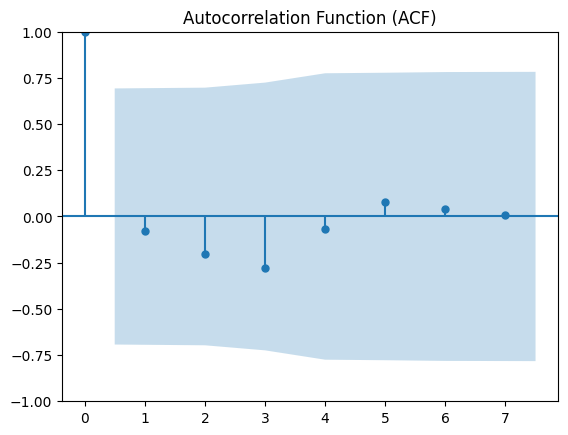

2


<Figure size 1200x600 with 0 Axes>

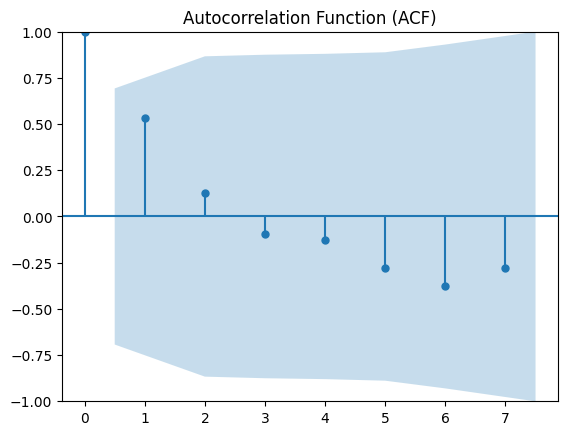

3


<Figure size 1200x600 with 0 Axes>

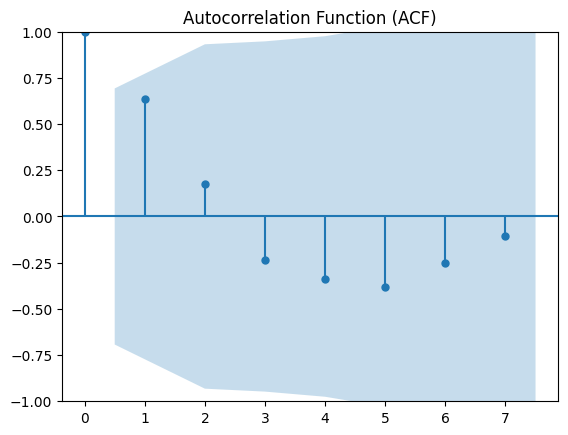

4


<Figure size 1200x600 with 0 Axes>

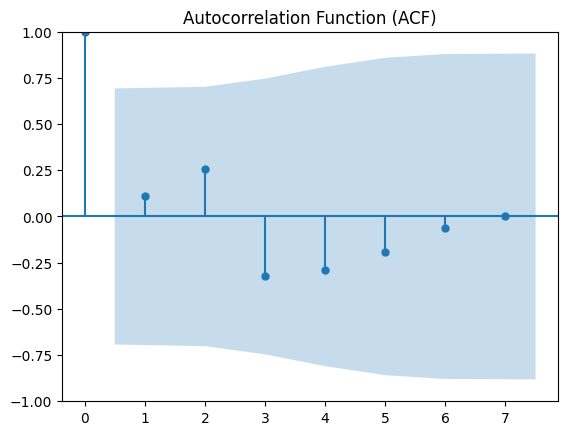

5


<Figure size 1200x600 with 0 Axes>

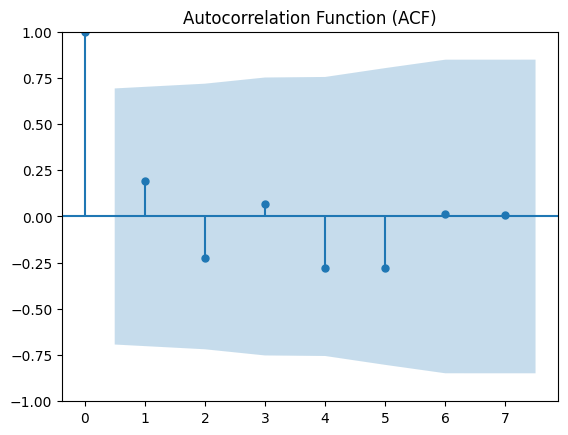

6


<Figure size 1200x600 with 0 Axes>

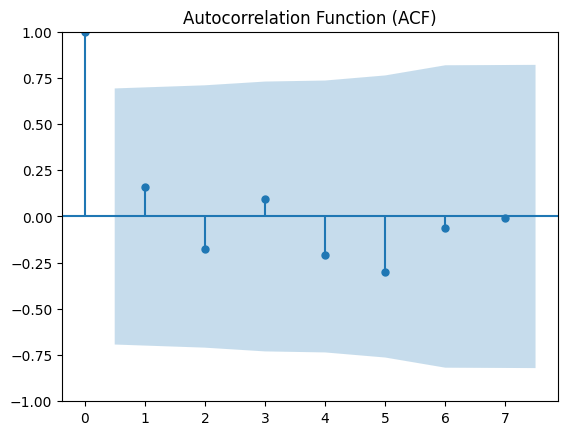

7


<Figure size 1200x600 with 0 Axes>

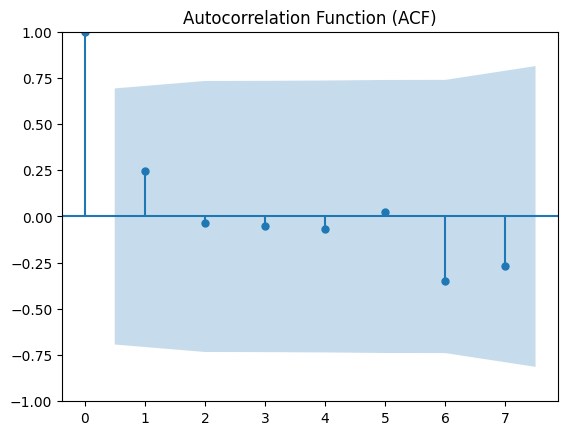

8


<Figure size 1200x600 with 0 Axes>

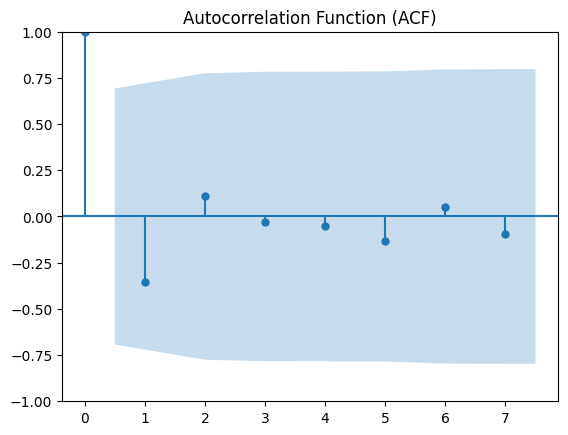

9


<Figure size 1200x600 with 0 Axes>

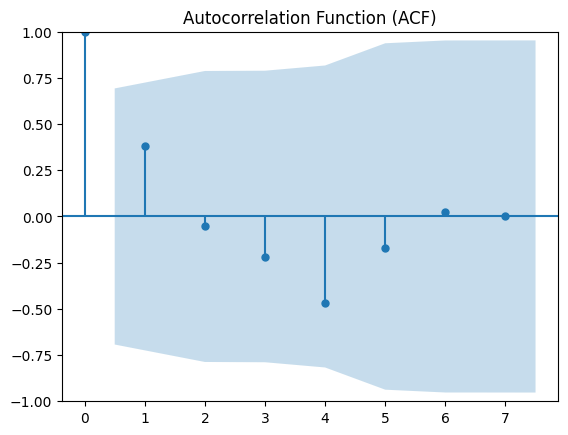

In [12]:
# Figure AutoCorrelations and Partial AutoCorrelations
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for i in range(batch-cnt_thrown_idx):
    print (i)
# Plot the autocorrelation function (ACF)    
    plt.figure(figsize = (12, 6))
    plot_acf(values[i], lags = sl - 1)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()
    
# Plot the partial autocorrelation function (PACF)
    # plt.figure(figsize = (12, 6))
    # plot_pacf(values[round(i/2)], lags = 60)
    # plt.title('Partial Autocorrelation Function (PACF)')
    # plt.show()

In [100]:
print ("===================================================")
print ("sequence length:  ", sl)
print ("batch size:  ", batch-cnt_thrown_idx)
print ("no. of variables:  ", n_features)
print ("no. of predicted variables:  ", n_out)
print ("how many steps forward to predict:  ", frwd)
print ("===================================================")
print ("input shape", X.shape)
print ("output shape", y.shape)

sequence length:   6
batch size:   10
no. of variables:   4
no. of predicted variables:   4
how many steps forward to predict:   1
input shape (10, 6, 4)
output shape (10, 1, 4)


In [103]:
n_steps = sl

model_2f = Sequential()
model_2f.add(tf.keras.layers.Input(shape = (n_steps, n_features)))
model_2f.add(tf.keras.layers.LSTM(units = 64, activation = 'relu', return_sequences = True))   
model_2f.add(tf.keras.layers.LSTM(units = 64, activation = 'relu', return_sequences = False))  

model_2f.add(tf.keras.layers.Dense(units = n_out))


model_2f.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_2f.summary()


# fit model
# The number of epochs is the number of complete passes through the training dataset
history = model_2f.fit(X, y, epochs = 100, 
                       validation_split = 0.2,
                       verbose = 2)
                       # , callbacks=[es])
                       # , callbacks = [TimeStepErrorLogger()])

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                  │ (None, 6, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,948 (199.02 KB)

 Trainable params: 50,948 (199.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 - 4s - 4s/step - loss: 0.3775 - val_loss: 0.3479
Epoch 2/100
1/1 - 0s - 49ms/step - loss: 0.3665 - val_loss: 0.3377
Epoch 3/100
1/1 - 0s - 47ms/step - loss: 0.3560 - val_loss: 0.3281
Epoch 4/100
1/1 - 0s - 47ms/step - loss: 0.3460 - val_loss: 0.3187
Epoch 5/100
1/1 - 0s - 47ms/step - loss: 0.3363 - val_loss: 0.3096
Epoch 6/100
1/1 - 0s - 47ms/step - loss: 0.3269 - val_loss: 0.3005
Epoch 7/100
1/1 - 0s - 47ms/step - loss: 0.3174 - val_loss: 0.2917
Epoch 8/100
1/1 - 0s - 47ms/step - loss: 0.3080 - val_loss: 0.2827
Epoch 9/100
1/1 - 0s - 47ms/step - loss: 0.2985 - val_loss: 0.2733
Epoch 10/100
1/1 - 0s - 47ms/step - loss: 0.2887 - val_loss: 0.2634
Epoch 11/100
1/1 - 0s - 47ms/step - loss: 0.2784 - val_loss: 0.2530
Epoch 12/100
1/1 - 0s - 47ms/step - loss: 0.2675 - val_loss: 0.2420
Epoch 13/100
1/1 - 0s - 47ms/step - loss: 0.2559 - val_loss: 0.2305
Epoch 14/100
1/1 - 0s - 48ms/step - loss: 0.2439 - val_loss: 0.2182
Epoch 15/100
1/1 - 0s - 47ms/step - loss: 0.2310 - val_loss

In [91]:
print ("input shape", X.shape)
print ("output shape", y.shape)

input shape (10, 16, 2)
output shape (10, 1, 2)


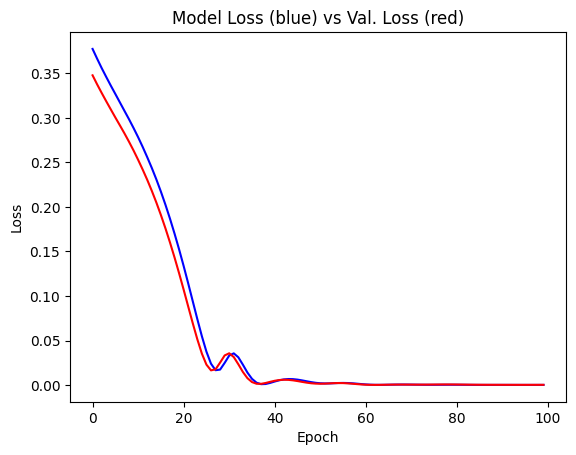

In [104]:
# Create a figure and axis object
fig, ax = plt.subplots(1, 1)

# Plot the data
ax.plot(history.history['loss'], 'blue')
ax.plot(history.history['val_loss'], 'red')

# Customize the plot
ax.set_title('Model Loss (blue) vs Val. Loss (red)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

plt.show()

In [23]:
# Extract weights from the LSTM layer
lstm_layer = model_2f.layers[0]
lstm_weights = lstm_layer.get_weights()

In [24]:
kernel, recurrent_kernel, bias = lstm_weights

# Print the shapes
print(f"Kernel shape: {kernel.shape}")
print(f"Recurrent Kernel shape: {recurrent_kernel.shape}")
print(f"Bias shape: {bias.shape}")

Kernel shape: (2, 96)
Recurrent Kernel shape: (24, 96)
Bias shape: (96,)


In [25]:
# Print the weights
print("Kernel weights:", kernel)
print("Recurrent kernel weights:", recurrent_kernel)
print("Bias weights:", bias)

Kernel weights: [[-0.14694473 -0.2149557   0.21574722 -0.03168026 -0.2404067   0.00060298
   0.17182997  0.00421425 -0.06863409  0.22241846  0.0680408   0.2418472
  -0.12803034 -0.15664381  0.15597875 -0.06085367  0.31251866 -0.02795665
  -0.03430395  0.17601249 -0.14519325 -0.2162165   0.1255817  -0.08926678
  -0.12125828  0.01932479 -0.12725121  0.2553787  -0.20190533 -0.19571888
   0.19269451 -0.15448165  0.00514798  0.05390324 -0.06658281 -0.23524462
   0.03737664  0.20991202 -0.0054796   0.13213603  0.16205935 -0.01213002
   0.1249122   0.08729742  0.23968889  0.22381271  0.22225435  0.14512493
   0.28880545 -0.1228936  -0.15207523  0.08161885 -0.1339008  -0.13070342
   0.24040265  0.17981866 -0.20574768  0.20776649  0.02432974 -0.14321205
   0.13607569 -0.19716436 -0.16750313  0.23942116  0.18560551  0.1364063
   0.12954217  0.06407089 -0.19326611 -0.05672123 -0.03679872 -0.06065868
   0.2761794  -0.1028993   0.10128753 -0.03650422  0.19155361  0.1891764
   0.21571362 -0.10350706

In [106]:
#  Validation Set - 06.20.2024
# ============================
# Reset Index
sample_valid = sample_valid.reset_index(drop = True)
sample_size = sample_valid.shape[0]
print ('sample_size: ', sample_size)
# sample_valid.head()
# sl = 8  # <--- sequence length
batch_valid = 6  # <--- batch size
# n_features = 8 # <---- no. of variables
# n_out = 1 # <----- no. of predicted variables
# frwd = 1  # <--- how many to predict

# Trimming Indices !!!
# Marking selected rows
sample_valid['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(374)
selected_indices = np.random.choice(sample_valid.index, size = batch_valid, replace = False)

sample_valid.loc[selected_indices, 'Selected'] = 1 # print (sample_valid[sample_valid['Selected'] == 1])
chosen_idx1 = sample_valid[sample_valid['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)

all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

all_ts_volume_xrp = np.empty((1, )) # final input/output
all_ts_volume_eth = np.empty((1, )) # final input/output
all_ts_volume_ltc = np.empty((1, )) # final input/output
all_ts_volume_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output


aft_ts_close_xrp = np.empty((1))
aft_ts_close_eth = np.empty((1))
aft_ts_close_ltc = np.empty((1))
aft_ts_close_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_valid.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_valid.iloc[max(0, idx): idx+frwd]

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  
    # Compute standard deviation
  std_dev_xrp = np.std(sr_before_close_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
  # print(std_dev_xrp_arr)
    
# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])
    # Compute standard deviation
  std_dev_eth = np.std(sr_before_close_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
  # print(std_dev_eth_arr)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])
# Compute standard deviation
  std_dev_ltc = np.std(sr_before_close_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
  # print(std_dev_ltc_arr)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])
    # Compute standard deviation
  std_dev_btc = np.std(sr_before_close_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
  # print(std_dev_btc_arr)

# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))
# ltc
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_ltc))
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))


  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))


X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]


X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]
X_BTC_stdev = stdev_btc[1:]

# print (X0)

X0_valid = np.column_stack((X_XRP_close,
                            X_ETH_close,
                            X_LTC_close,
                            X_BTC_close
                           ))

# ======== Model Input =========
X_valid = X0_valid.reshape(batch_valid-cnt_thrown_idx, sl, n_features)
print ('XXXX ====== Actual Input ====== XXXX')
print (X_valid)
print (X_valid.shape)


y_XRP = aft_ts_close_xrp[1:]
y_ETH = aft_ts_close_eth[1:]
y_LTC = aft_ts_close_ltc[1:]
y_BTC = aft_ts_close_btc[1:]

y0_valid = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
# print (y0)

y_valid = y0_valid.reshape(batch_valid-cnt_thrown_idx, frwd, n_out)
print ('YYYY ====== Actual Input ====== YYYY')
print (y_valid)
print (y_valid.shape)

sample_size:  5345
[2705 2304 2028 3132  245 3235]
XXXX ====== Actual Input ====== XXXX
[[[0.5233    0.383067  0.8573    0.7105592]
  [0.5235    0.383102  0.8574    0.7105005]
  [0.5243    0.383687  0.8538    0.710517 ]
  [0.5239    0.383284  0.8528    0.7100418]
  [0.5238    0.382979  0.8526    0.7097535]
  [0.5229    0.3827    0.8522    0.7088585]]

 [[0.4988    0.367839  0.8013    0.693467 ]
  [0.4988    0.367874  0.801     0.6934189]
  [0.4988    0.367842  0.801     0.6933052]
  [0.4988    0.367842  0.8013    0.6929601]
  [0.4987    0.36782   0.8014    0.6931277]
  [0.4989    0.367874  0.8014    0.6932936]]

 [[0.5228    0.382313  0.8426    0.7126844]
  [0.5227    0.382009  0.8424    0.7121888]
  [0.5225    0.381963  0.842     0.7122303]
  [0.5226    0.381978  0.8422    0.7124799]
  [0.5224    0.381945  0.8419    0.7124184]
  [0.5225    0.381966  0.8419    0.7123872]]

 [[0.4931    0.368402  0.7943    0.6936869]
  [0.4932    0.368171  0.7941    0.6934014]
  [0.4973    0.369449  0.8

In [134]:
y_valid = y_valid.reshape(batch_valid-cnt_thrown_idx, n_out)
print ('y_valid')
print (type(y_valid))
print (y_valid.shape)
print (y_valid)
# print (y_valid[0:10])

y_hat = model_2f.predict(X_valid, verbose = 1)
# .reshape(batch_valid-cnt_thrown_idx, frwd)
# print (sl)


print ('y_hat')
print (type(y_hat))
print (y_hat.shape)
print (y_hat)
# y_ht1 = y_hat.reshape(batch-cnt_thrown_idx, frwd)
# # print (y_hat[0:10])
# print (y_ht1)

y_valid
<class 'numpy.ndarray'>
(6, 4)
[[0.5233    0.382751  0.8576    0.7103601]
 [0.4987    0.367886  0.8014    0.693385 ]
 [0.5223    0.381907  0.8415    0.7122137]
 [0.4925    0.368111  0.794     0.6931971]
 [0.4937    0.368967  0.7971    0.6947576]
 [0.5       0.368552  0.8041    0.6938843]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
y_hat
<class 'numpy.ndarray'>
(6, 4)
[[0.52473974 0.38107908 0.8461987  0.7331535 ]
 [0.5036733  0.36514583 0.80844265 0.70000196]
 [0.523268   0.37977216 0.8430245  0.7305254 ]
 [0.5026271  0.36427632 0.80654866 0.6983792 ]
 [0.50249064 0.36416662 0.80624986 0.6981052 ]
 [0.50450474 0.36577496 0.80995065 0.7013234 ]]


In [170]:
print (y_valid[0])
print (y_hat[0])

[0.5233    0.382751  0.8576    0.7103601]
[0.52473974 0.38107908 0.8461987  0.7331535 ]


      XRP       ETH     LTC       BTC
0  0.5233  0.383067  0.8573  0.710559
1  0.5235  0.383102  0.8574  0.710500
2  0.5243  0.383687  0.8538  0.710517
3  0.5239  0.383284  0.8528  0.710042
4  0.5238  0.382979  0.8526  0.709754
5  0.5229  0.382700  0.8522  0.708859
6  0.5233  0.382751  0.8576  0.710360
       XRP       ETH       LTC       BTC
0  0.52330  0.383067  0.857300  0.710559
1  0.52350  0.383102  0.857400  0.710500
2  0.52430  0.383687  0.853800  0.710517
3  0.52390  0.383284  0.852800  0.710042
4  0.52380  0.382979  0.852600  0.709754
5  0.52290  0.382700  0.852200  0.708859
6  0.52474  0.381079  0.846199  0.733154


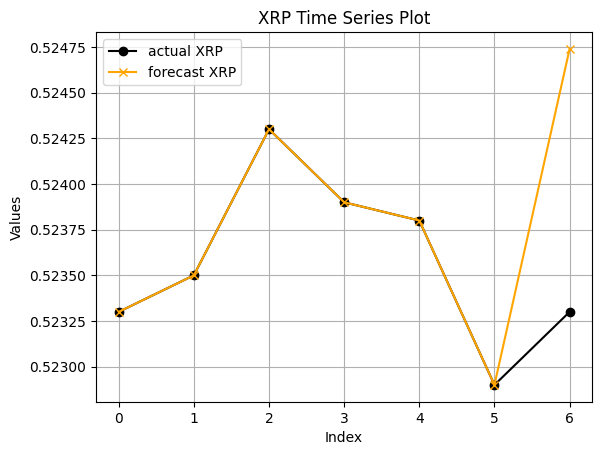

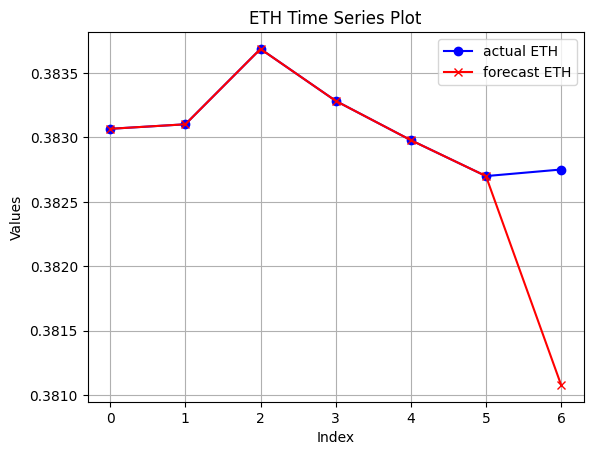

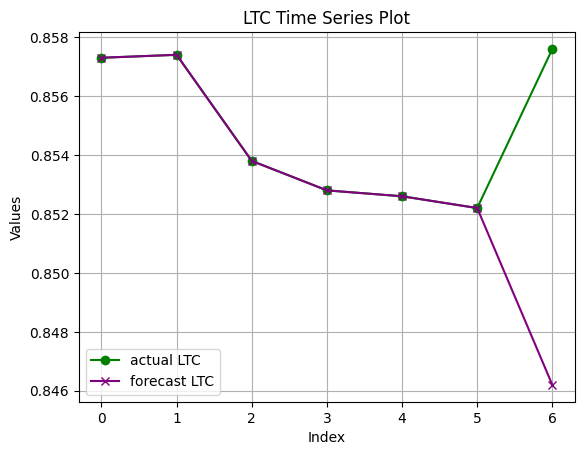

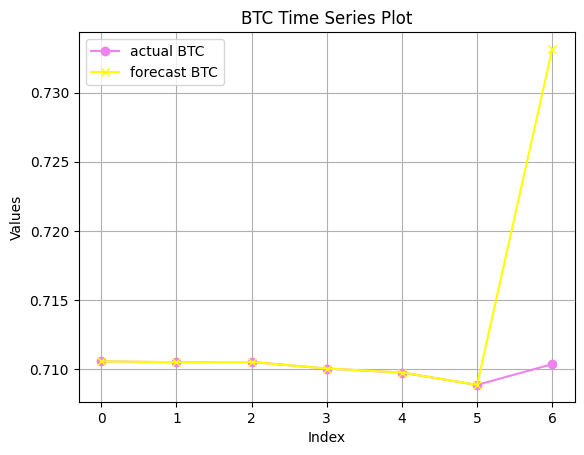

      XRP       ETH     LTC       BTC
0  0.4988  0.367839  0.8013  0.693467
1  0.4988  0.367874  0.8010  0.693419
2  0.4988  0.367842  0.8010  0.693305
3  0.4988  0.367842  0.8013  0.692960
4  0.4987  0.367820  0.8014  0.693128
5  0.4989  0.367874  0.8014  0.693294
6  0.4987  0.367886  0.8014  0.693385
        XRP       ETH       LTC       BTC
0  0.498800  0.367839  0.801300  0.693467
1  0.498800  0.367874  0.801000  0.693419
2  0.498800  0.367842  0.801000  0.693305
3  0.498800  0.367842  0.801300  0.692960
4  0.498700  0.367820  0.801400  0.693128
5  0.498900  0.367874  0.801400  0.693294
6  0.503673  0.365146  0.808443  0.700002


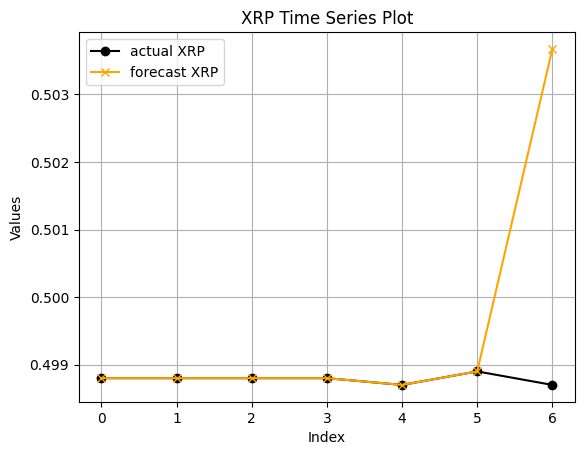

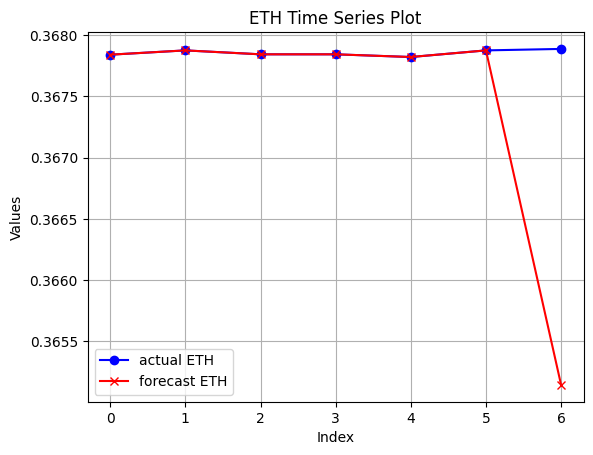

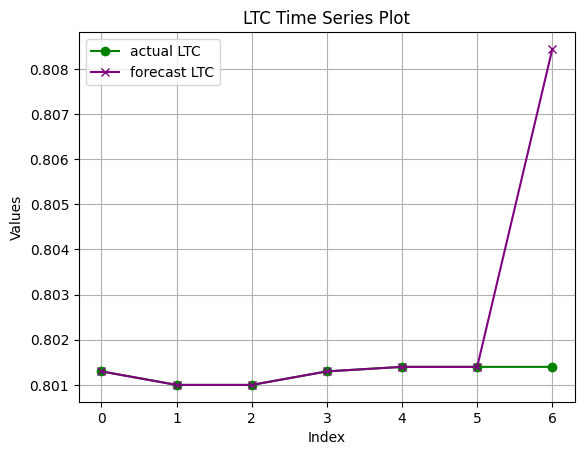

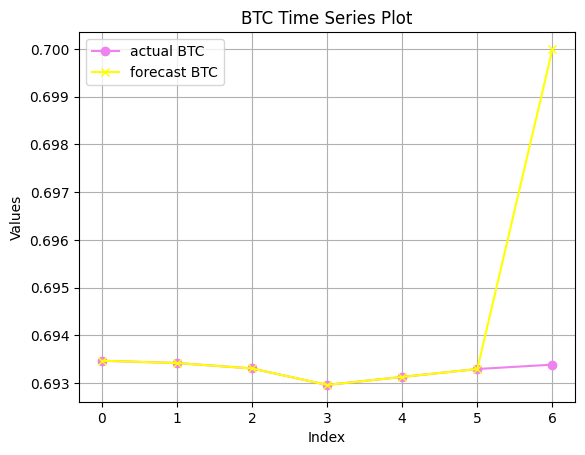

      XRP       ETH     LTC       BTC
0  0.5228  0.382313  0.8426  0.712684
1  0.5227  0.382009  0.8424  0.712189
2  0.5225  0.381963  0.8420  0.712230
3  0.5226  0.381978  0.8422  0.712480
4  0.5224  0.381945  0.8419  0.712418
5  0.5225  0.381966  0.8419  0.712387
6  0.5223  0.381907  0.8415  0.712214
        XRP       ETH       LTC       BTC
0  0.522800  0.382313  0.842600  0.712684
1  0.522700  0.382009  0.842400  0.712189
2  0.522500  0.381963  0.842000  0.712230
3  0.522600  0.381978  0.842200  0.712480
4  0.522400  0.381945  0.841900  0.712418
5  0.522500  0.381966  0.841900  0.712387
6  0.523268  0.379772  0.843024  0.730525


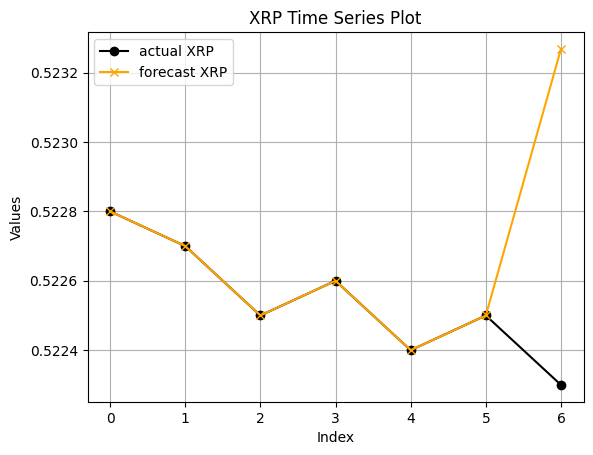

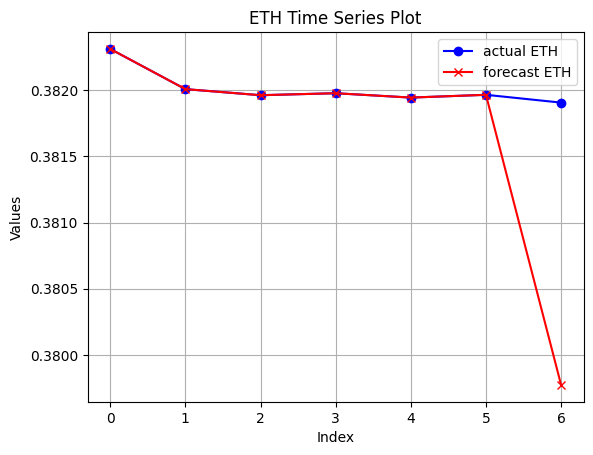

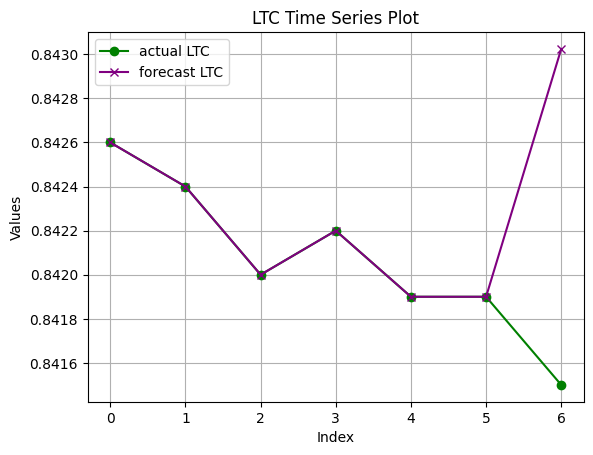

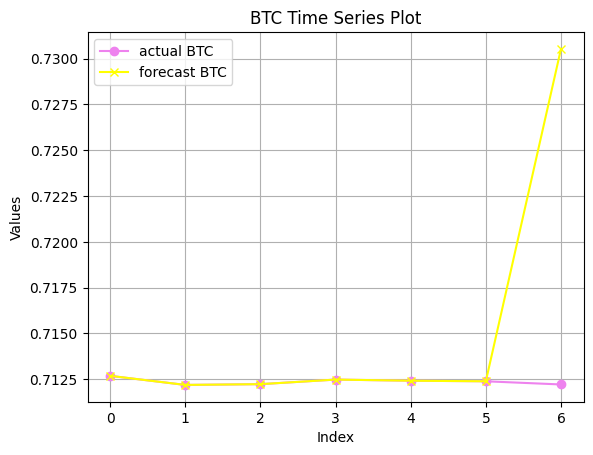

      XRP       ETH     LTC       BTC
0  0.4931  0.368402  0.7943  0.693687
1  0.4932  0.368171  0.7941  0.693401
2  0.4973  0.369449  0.8000  0.694914
3  0.4972  0.369305  0.7997  0.694689
4  0.4970  0.369176  0.7992  0.694571
5  0.4965  0.368981  0.7983  0.694393
6  0.4925  0.368111  0.7940  0.693197
        XRP       ETH       LTC       BTC
0  0.493100  0.368402  0.794300  0.693687
1  0.493200  0.368171  0.794100  0.693401
2  0.497300  0.369449  0.800000  0.694914
3  0.497200  0.369305  0.799700  0.694689
4  0.497000  0.369176  0.799200  0.694571
5  0.496500  0.368981  0.798300  0.694393
6  0.502627  0.364276  0.806549  0.698379


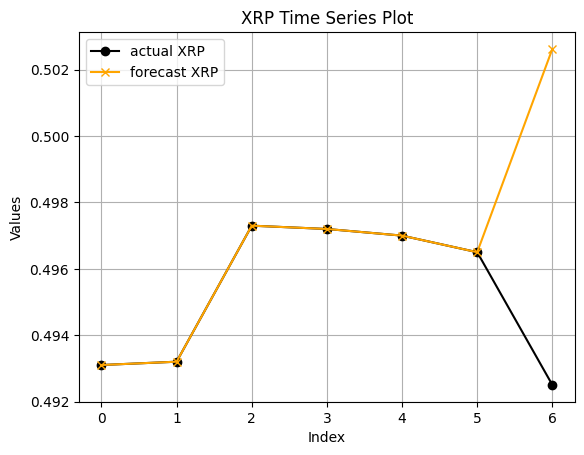

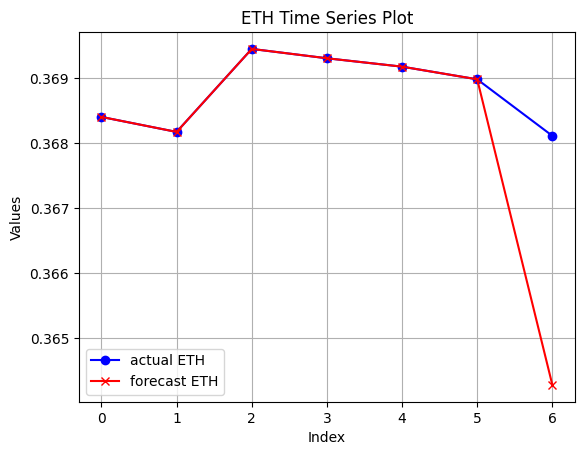

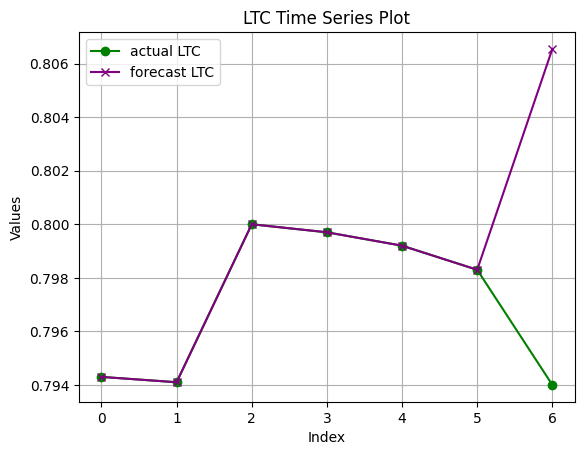

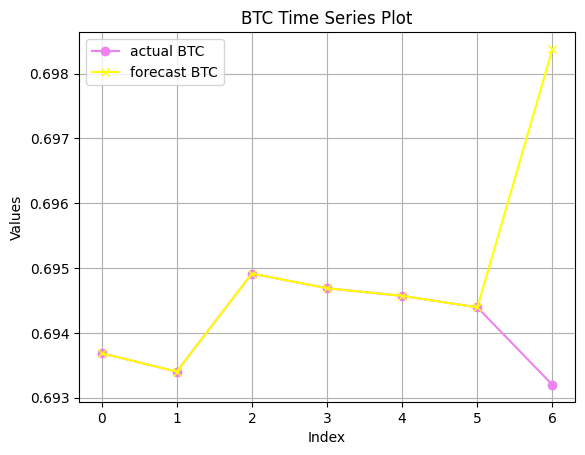

      XRP       ETH     LTC       BTC
0  0.4939  0.369107  0.7980  0.694802
1  0.4940  0.369145  0.7970  0.694704
2  0.4938  0.368975  0.7969  0.694642
3  0.4936  0.368882  0.7966  0.694645
4  0.4937  0.368987  0.7970  0.694803
5  0.4937  0.368850  0.7966  0.694690
6  0.4937  0.368967  0.7971  0.694758
        XRP       ETH      LTC       BTC
0  0.493900  0.369107  0.79800  0.694802
1  0.494000  0.369145  0.79700  0.694704
2  0.493800  0.368975  0.79690  0.694642
3  0.493600  0.368882  0.79660  0.694645
4  0.493700  0.368987  0.79700  0.694803
5  0.493700  0.368850  0.79660  0.694690
6  0.502491  0.364167  0.80625  0.698105


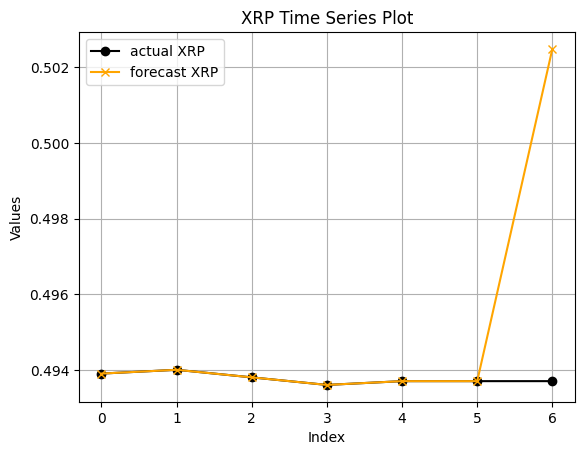

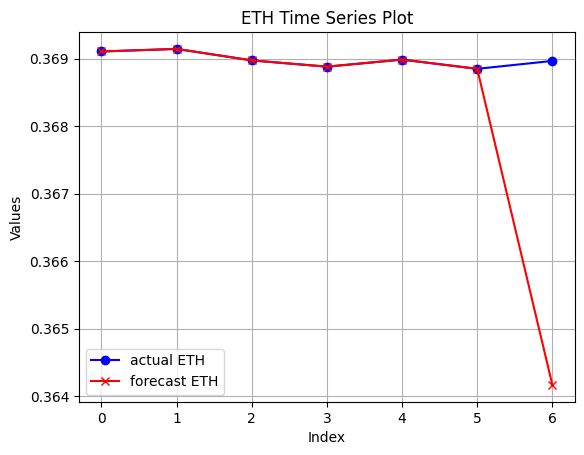

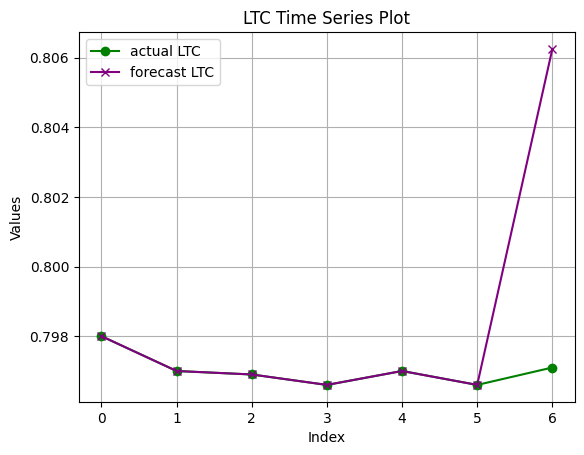

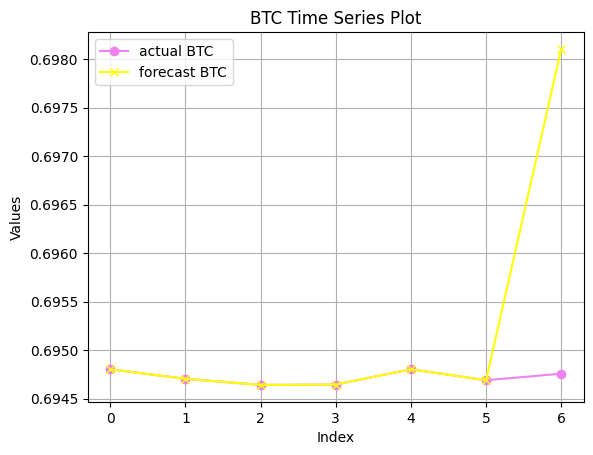

      XRP       ETH     LTC       BTC
0  0.4998  0.368504  0.8036  0.694010
1  0.4987  0.368769  0.8021  0.694039
2  0.5000  0.368602  0.8042  0.694019
3  0.4998  0.368501  0.8039  0.693838
4  0.5000  0.368537  0.8040  0.694019
5  0.5002  0.368528  0.8039  0.693984
6  0.5000  0.368552  0.8041  0.693884
        XRP       ETH       LTC       BTC
0  0.499800  0.368504  0.803600  0.694010
1  0.498700  0.368769  0.802100  0.694039
2  0.500000  0.368602  0.804200  0.694019
3  0.499800  0.368501  0.803900  0.693838
4  0.500000  0.368537  0.804000  0.694019
5  0.500200  0.368528  0.803900  0.693984
6  0.504505  0.365775  0.809951  0.701323


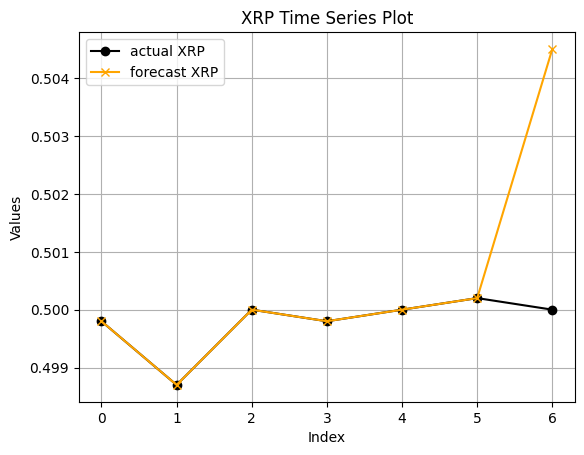

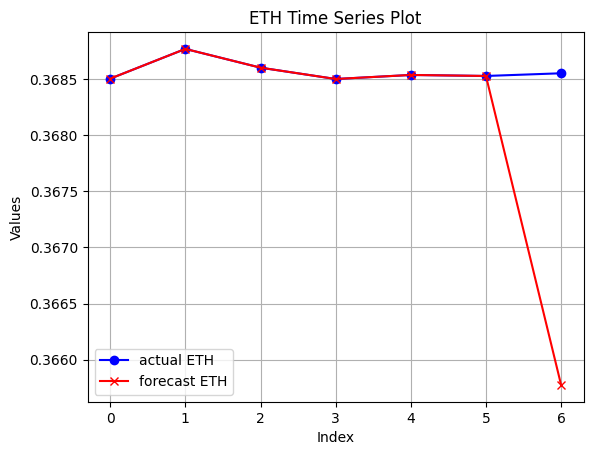

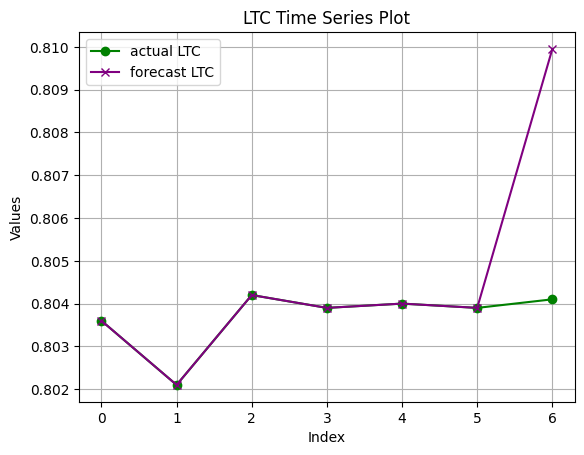

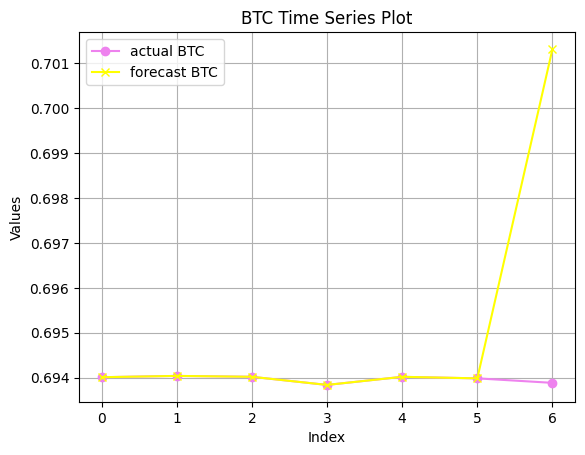

In [189]:
for i in range(batch_valid):
    actual = pd.concat([pd.DataFrame(X_valid[i], columns = ['XRP', 'ETH', 'LTC', 'BTC']),  
                        pd.DataFrame(y_valid[i].reshape(1, 4), columns = ['XRP', 'ETH', 'LTC', 'BTC'])], 
                        ignore_index = True)
    print(actual)
    
    forecast = pd.concat([pd.DataFrame(X_valid[i], columns = ['XRP', 'ETH', 'LTC', 'BTC']),  
                          pd.DataFrame(y_hat[i].reshape(1, 4), columns = ['XRP', 'ETH', 'LTC', 'BTC'])], 
                          ignore_index = True)
    print(forecast)

# =================== XPR ======================== 
    fig, ax = plt.subplots()
    
    ax.plot(actual.index, actual['XRP'], label = 'actual XRP', marker = 'o', color = 'black')
    ax.plot(forecast.index, forecast['XRP'], label = 'forecast XRP', marker = 'x', color = 'orange')
  
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('XRP Time Series Plot')
 
    ax.legend() # Add legend

    ax.grid(True) # Add grid
    
    plt.show()
# =================== ETH ========================
    fig, ax = plt.subplots()
    ax.plot(actual.index, actual['ETH'], label = 'actual ETH', marker = 'o', color = 'blue')
    ax.plot(forecast.index, forecast['ETH'], label = 'forecast ETH', marker = 'x', color = 'red')
    
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('ETH Time Series Plot')

    ax.legend() # Add legend

    ax.grid(True) # Add grid
    
    plt.show()

# =================== LTC ========================
    fig, ax = plt.subplots()
    
    ax.plot(actual.index, actual['LTC'], label = 'actual LTC', marker = 'o', color = 'green')
    ax.plot(forecast.index, forecast['LTC'], label = 'forecast LTC', marker = 'x', color = 'purple')

    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('LTC Time Series Plot')
    
    ax.legend() # Add legend

    ax.grid(True) # Add grid
    
    plt.show()
    
# =================== BTC ========================
    fig, ax = plt.subplots()
    
    ax.plot(actual.index, actual['BTC'], label = 'actual BTC', marker = 'o', color = 'violet')
    ax.plot(forecast.index, forecast['BTC'], label = 'forecast BTC', marker = 'x', color = 'yellow')
    
    # Add labels and a title
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('BTC Time Series Plot')

    ax.legend() # Add legend

    ax.grid(True) # Add grid
    
    plt.show()

In [156]:
time_index = list(range(sl+frwd))
print (time_index)

print (range(actual.shape[1]))

[0, 1, 2, 3, 4, 5, 6]
range(0, 4)


In [135]:
print (type(X_valid[0]))
print (shape(X_valid[0]))
print (X_valid[0])

<class 'numpy.ndarray'>
(6, 4)
[[0.5233    0.383067  0.8573    0.7105592]
 [0.5235    0.383102  0.8574    0.7105005]
 [0.5243    0.383687  0.8538    0.710517 ]
 [0.5239    0.383284  0.8528    0.7100418]
 [0.5238    0.382979  0.8526    0.7097535]
 [0.5229    0.3827    0.8522    0.7088585]]


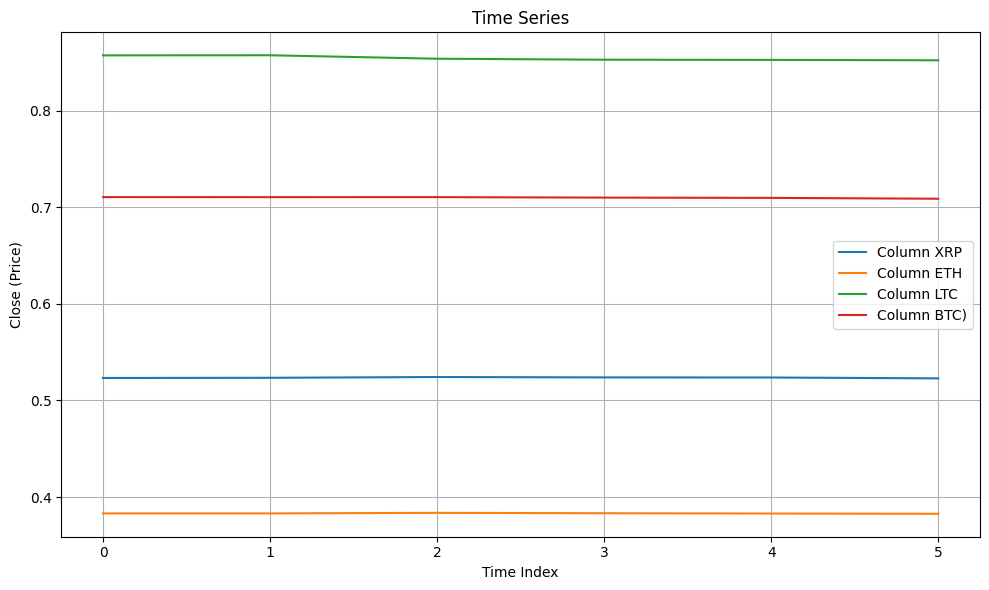

In [136]:
# Create a time index (assuming each row is a time point)
# time_index = np.arange(len(X_valid[0]))  # This will create [0, 1, 2, 3, 4, 5] as the index

time_index = list(range(sl))

column_names = ['XRP', 'ETH', 'LTC', 'BTC)']

# Create figure and axes objects using object-oriented approach
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each column as a separate line
for i in range(X_valid[0].shape[1]):
    ax.plot(time_index, data[:, i], label = f'Column {column_names[i]}')

# Customize plot elements
ax.set_xlabel('Time Index')
ax.set_ylabel('Close (Price)')
ax.set_title('Time Series')
ax.legend()

ax.grid(True)
fig.tight_layout()

plt.show()

In [123]:

for i in range(batch_valid-cnt_thrown_idx):
    print ('\n')  
    print (i)
    print (X_valid[i])



0
[[0.5233    0.383067  0.8573    0.7105592]
 [0.5235    0.383102  0.8574    0.7105005]
 [0.5243    0.383687  0.8538    0.710517 ]
 [0.5239    0.383284  0.8528    0.7100418]
 [0.5238    0.382979  0.8526    0.7097535]
 [0.5229    0.3827    0.8522    0.7088585]]


1
[[0.4988    0.367839  0.8013    0.693467 ]
 [0.4988    0.367874  0.801     0.6934189]
 [0.4988    0.367842  0.801     0.6933052]
 [0.4988    0.367842  0.8013    0.6929601]
 [0.4987    0.36782   0.8014    0.6931277]
 [0.4989    0.367874  0.8014    0.6932936]]


2
[[0.5228    0.382313  0.8426    0.7126844]
 [0.5227    0.382009  0.8424    0.7121888]
 [0.5225    0.381963  0.842     0.7122303]
 [0.5226    0.381978  0.8422    0.7124799]
 [0.5224    0.381945  0.8419    0.7124184]
 [0.5225    0.381966  0.8419    0.7123872]]


3
[[0.4931    0.368402  0.7943    0.6936869]
 [0.4932    0.368171  0.7941    0.6934014]
 [0.4973    0.369449  0.8       0.694914 ]
 [0.4972    0.369305  0.7997    0.6946885]
 [0.497     0.369176  0.7992    0.6

In [109]:
for i in range(batch_valid-cnt_thrown_idx):
    print ('\n')  
    print (i)
    X_resh = X_valid[i:i+1, :, 6].flatten()
    # print (X_resh)
    # print ('\n')
    y_resh = y_valid[i:i+1].flatten()
    # print (y_resh)
    y_est_resh = y_hat[i:i+1].flatten()
    # print (y_est_resh)
    # print ('\n')
    actual = np.concatenate((X_resh, y_resh)) 
    # print (actual)
    # print ('\n')
    estimate = np.concatenate((X_resh, y_est_resh))
    # print (estimate)

    dates = list(range(sl+frwd))
    
    # Create a pandas DataFrame
    data = pd.DataFrame({'Date': dates, 'Actuals': actual, 'Forecasts': estimate})
    
    # Set the 'Date' column as the index
    data.set_index('Date', inplace=True)
    
    # Create a figure and axis object using object-oriented style
    fig, ax = plt.subplots(figsize = (10, 6))
    
    # Plot actuals vs. forecasts
    ax.plot(data.index, data['Forecasts'], label = 'Forecasts', marker = 'x')
    ax.plot(data.index, data['Actuals'], label = 'Actuals', marker = 'o')
    
    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title('Actuals vs. Forecasts')

    ax.legend() # Add legend

    ax.grid(True) # Add grid
    
    plt.show()



0


ValueError: All arrays must be of the same length

In [255]:
print (sample_test.head(1))

    date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  vwap_eth  \
0  1-0-0     0.5173  28809.165339  0.517217   0.376204   37.497964  0.376108   

   close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  vwap_btc  Selected  
0     0.8317  110.056253  0.831662    0.67506    2.045049  0.674969         0  


In [1]:
# variables are volume and volume
# ==============================
#  Test Sample --- 06.14.2024
# ==============================
sample_size = sample_test.shape[0]
print ('sample_size: ', sample_size)

sl = 16  # <--- sequence length
batch = 10  # <--- batch size
n_features = 8 # <---- no. of variables
n_out = 1 # <----- no. of predicted variables
frwd = 1  # <--- how many to predict


# Trimming Indices !!!
# Marking selected rows
sample_test['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_test.index, size = batch, replace = False)

sample_test.loc[selected_indices, 'Selected'] = 1 # print (sample_test[sample_test['Selected'] == 1])
chosen_idx1 = sample_test[sample_test['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)

# all_ts_xrp = np.empty((1, )) # final input/output
# all_ts_eth = np.empty((1, )) # final input/output
# all_ts_ltc = np.empty((1, )) # final input/output
# all_ts_btc = np.empty((1, )) # final input/output


all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

all_ts_volume_xrp = np.empty((1, )) # final input/output
all_ts_volume_eth = np.empty((1, )) # final input/output
all_ts_volume_ltc = np.empty((1, )) # final input/output
all_ts_volume_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output


aft_ts_xrp = np.empty((1))
aft_ts_eth = np.empty((1))
aft_ts_ltc = np.empty((1))
aft_ts_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_test.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_test.iloc[max(0, idx): idx+frwd]

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  
    # Compute standard deviation
  std_dev_xrp = np.std(sr_before_close_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
  # print(std_dev_xrp_arr)
    
# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])
    # Compute standard deviation
  std_dev_eth = np.std(sr_before_close_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
  # print(std_dev_eth_arr)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])
# Compute standard deviation
  std_dev_ltc = np.std(sr_before_close_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
  # print(std_dev_ltc_arr)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])
    # Compute standard deviation
  std_dev_btc = np.std(sr_before_close_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
  # print(std_dev_btc_arr)

# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))
# ltc
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_tc))
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))


  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))


X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]


X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]
X_BTC_stdev = stdev_btc[1:]

X0 = np.column_stack((X_XRP_close, X_XRP_volume, 
                      X_ETH_close, X_ETH_volume, 
                      X_LTC_close, X_LTC_volume, 
                      X_BTC_close, X_BTC_volume))
print (X0)

# ======== Model Input =========
X = X0.reshape(batch-cnt_thrown_idx, sl, n_features)
print ('XXXX ====== Actual Input ====== XXXX')
print (X.shape)

y_XRP = aft_ts_xrp[1:]
y_ETH = aft_ts_eth[1:]
y_LTC = aft_ts_ltc[1:]
y_BTC = aft_ts_btc[1:]

y = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
print (y)

y = y_BTC.reshape(batch-cnt_thrown_idx, frwd, n_out)
# print ('YYYY ====== Actual Input ====== YYYY')
print (y.shape)

NameError: name 'sample_test' is not defined